# Introduction

This project will focus on exploring the capabilities of Bayesian optimization, specifically employing BayBE, in the discovery of novel corrosion inhibitors for materials design. Initially, we will work with a randomly chosen subset from a comprehensive database of electrochemical responses of small organic molecules. Our goal is to assess how Bayesian optimization can speed up the screening process across the design space to identify promising compounds. We will compare different strategies for incorporating alloy information, while optimizing the experimental parameters with respect to the inhibitive performance of the screened compounds.

# Initialization

Loading libraries and data files:

In [68]:
import pandas as pd
import numpy as np
from baybe import Campaign

df_AA2024 = pd.read_excel('../data/averaged_filtered_AA2024.xlsx')
df_AA1000 = pd.read_excel('../data/averaged_filtered_AA1000.xlsx')
df_Al = pd.read_excel('../data/averaged_filtered_Al.xlsx')

df_active = df_AA2024
lookup = df_active

In [69]:
import numpy as np

def random_subsample(df, num_samples):
    np.random.seed(42)
    indices = np.random.choice(df.index, num_samples, replace=False)
    subsampled_df = df.loc[indices]
    return subsampled_df 

In [70]:
df_active.head()

,SMILES,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency
0,C(=O)(C(=O)[O-])[O-],24.0,4.0,0.0010,0.10,20.00
1,C(=O)(C(=O)[O-])[O-],24.0,7.0,0.0005,0.05,12.35
2,C(=O)(C(=O)[O-])[O-],24.0,10.0,0.0010,0.10,20.00
3,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,4.0,0.0010,0.10,30.00
4,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,7.0,0.0005,0.05,-23.95


In [71]:
unique_smiles = df_active.SMILES.unique()
unique_times = df_active.Time_h.unique()
unique_pH = df_active.pH.unique()
unique_inhib_conc = df_active.Inhib_Concentrat_M.unique()
unique_salt_conc = df_active.Salt_Concentrat_M.unique()

time_min, time_max = df_active.Time_h.min(), df_active.Time_h.max()
pH_min, pH_max = df_active.pH.min(), df_active.pH.max()
inhib_conc_min, inhib_conc_max = df_active.Inhib_Concentrat_M.min(), df_active.Inhib_Concentrat_M.max()
salt_conc_min, salt_conc_max = df_active.Salt_Concentrat_M.min(), df_active.Salt_Concentrat_M.max()
efficiency_min, efficiency_max = df_active.Efficiency.min(), df_active.Efficiency.max()

# Data Processing

# Data Anaylsis

# Bayesian Optimization

In [72]:
from baybe import Campaign

from baybe.targets import NumericalTarget
from baybe.objective import Objective
from baybe.searchspace import SearchSpace
from baybe.parameters import NumericalDiscreteParameter
from baybe.parameters import SubstanceParameter

import matplotlib.pyplot as plt
import seaborn as sns

def list_to_dict(input_list):
    return {item: item for item in input_list}

smiles_dict =list_to_dict(unique_smiles)


target = NumericalTarget(name="Efficiency", mode="MAX", bounds=(efficiency_min, efficiency_max), transformation="LINEAR")
objective = Objective(mode="SINGLE", targets=[target])



parameters = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_active['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_active['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_active['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_active['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="MORGAN_FP",  # optional
    decorrelate=0.7,  # optional
    )        
    ]
# searchspace = SubspaceDiscrete.from_product(parameters=parameters)
df_no_target = df_active.drop('Efficiency', axis=1)

searchspace = SearchSpace.from_dataframe(df = df_no_target, parameters=parameters)

campaign = Campaign(
    searchspace=searchspace,  # Required
    objective=objective,  # Required
    # recommender=recommender,  # Optional
)

In [73]:
from baybe.recommenders import RandomRecommender

campaign_rand = Campaign(
    searchspace=searchspace,
    recommender=RandomRecommender(),
    objective=objective,
)

In [74]:
substance_encodings = ["MORDRED", "RDKIT", "MORGAN_FP"]
scenarios = {
    encoding: Campaign(
        searchspace=SearchSpace.from_dataframe(df = df_no_target,
            parameters=[
                NumericalDiscreteParameter(
                    name="Time_h",
                    values=df_active["Time_h"].unique(),
                    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
                ),
                NumericalDiscreteParameter(
                    name="pH",
                    values=df_active["pH"].unique(),
                    # tolerance = 0.004
                ),
                NumericalDiscreteParameter(  # Set this as continuous, the values seem quite small?
                    name="Inhib_Concentrat_M",
                    values=df_active["Inhib_Concentrat_M"].unique(),
                    # tolerance = 0.004
                ),
                NumericalDiscreteParameter(
                    name="Salt_Concentrat_M",
                    values=df_active["Salt_Concentrat_M"].unique(),
                    # tolerance = 0.004
                ),
                SubstanceParameter(
                    name="SMILES",
                    data=smiles_dict,
                    encoding=encoding,  # optional
                    decorrelate=0.7,  # optional
                ),
            ]
        ),
        objective=objective,
    )
    for encoding in substance_encodings
}

In [75]:
scenarios.update({"Random Baseline": campaign_rand})

In [76]:
from baybe.simulation import simulate_experiment
from baybe.simulation import simulate_scenarios


BATCH_SIZE = 1
N_DOE_ITERATIONS = 50
N_MC_ITERATIONS = 10

# results = simulate_experiment(
#     campaign,
#     df_AA2024,
#     initial_data=initial_dataset,
#     batch_size=BATCH_SIZE,
#     n_doe_iterations=N_DOE_ITERATIONS,
#     impute_mode="best",
# )
initial_dataset = random_subsample(df_active, 5)

results = simulate_scenarios(
    scenarios,
    lookup,
    initial_data=[initial_dataset],
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    # n_mc_iterations=N_MC_ITERATIONS,
    impute_mode="best",
)

100%|##########| 4/4 [01:05<00:00, 16.27s/it]


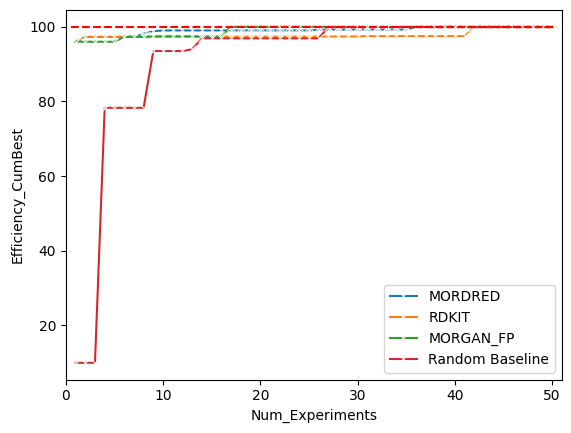

In [77]:
max_efficiency = lookup["Efficiency"].max()
# plot_results = results[results['Scenario'].isin(['Mordred', 'Morgan', 'RDKIT'])]

sns.lineplot(
    data=results, x="Num_Experiments", y="Efficiency_CumBest", hue="Scenario", marker="x"
)
plt.plot([0.5, N_DOE_ITERATIONS+0.5], [max_efficiency, max_efficiency], "--r")
plt.legend(loc="lower right")
import matplotlib.pyplot as plt

plt.xlim(0, N_DOE_ITERATIONS+1)
plt.savefig("./AA1000_simulation_10MC_50exp_1batch.png")

## Search Space

## Target & Objective

## Recommender

# Benchmarking

# Transfer Learning

In [110]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from botorch.test_functions.synthetic import Hartmann

from baybe import Campaign
from baybe.objective import Objective
from baybe.parameters import NumericalDiscreteParameter, TaskParameter, CategoricalParameter
from baybe.searchspace import SearchSpace
from baybe.simulation import simulate_scenarios, simulate_transfer_learning
from baybe.targets import NumericalTarget
from baybe.utils.botorch_wrapper import botorch_function_wrapper
from baybe.utils.plotting import create_example_plots


In [111]:


SMOKE_TEST = "SMOKE_TEST" in os.environ  # reduce the problem complexity in CI pipelines
DIMENSION = 3  # input dimensionality of the test function
BATCH_SIZE = 1  # batch size of recommendations per DOE iteration
N_MC_ITERATIONS = 2 if SMOKE_TEST else 50  # number of Monte Carlo runs
N_DOE_ITERATIONS = 2 if SMOKE_TEST else 10  # number of DOE iterations
POINTS_PER_DIM = 3 if SMOKE_TEST else 7  # number of grid points per input dimension


In [112]:
df_AA2024 = pd.read_excel('../data/averaged_filtered_AA2024.xlsx')
df_AA2024["alloy"] = "AA2024"
df_AA1000 = pd.read_excel('../data/averaged_filtered_AA1000.xlsx')
df_AA1000["alloy"] = "AA1000"
df_AA5000 = pd.read_excel('../data/averaged_filtered_AA5000.xlsx')
df_AA5000["alloy"] = "AA5000"
df_AA6000 = pd.read_excel('../data/averaged_filtered_AA6000.xlsx')
df_AA6000["alloy"] = "AA6000"
df_AA7075 = pd.read_excel('../data/averaged_filtered_AA7075.xlsx')
df_AA7075["alloy"] = "AA7075"
df_Al = pd.read_excel('../data/averaged_filtered_Al.xlsx')

In [113]:
target = NumericalTarget(name="Efficiency", mode="MAX", bounds=(efficiency_min, efficiency_max), transformation="LINEAR")
objective = Objective(mode="SINGLE", targets=[target])

In [133]:
df_combined = pd.concat([df_AA2024, df_AA1000, df_AA5000, df_AA6000, df_AA7075], axis=0).reset_index(drop=True)
# df_active = df_AA2024
lookup = df_combined

In [145]:
def list_to_dict(input_list):
    return {item: item for item in input_list}

smiles_dict =list_to_dict(df_combined.SMILES.unique())

discrete_params = [
NumericalDiscreteParameter(
    name="Time_h",
    values=df_combined['Time_h'].unique(),
    # tolerance = 0.004, assume certain experimental noise for each parameter measurement?
),
NumericalDiscreteParameter(
    name="pH",
    values=df_combined['pH'].unique(),
    # tolerance = 0.004
    ),  
NumericalDiscreteParameter( # Set this as continuous, the values seem quite small?
    name="Inhib_Concentrat_M",
    values= df_combined['Inhib_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
NumericalDiscreteParameter(
    name="Salt_Concentrat_M",
    values=df_combined['Salt_Concentrat_M'].unique(),
    # tolerance = 0.004
    ),
# CategoricalParameter(
#     name="alloy",
#     values=df_combined['alloy'].unique(),
#     ),
SubstanceParameter(
    name="SMILES",
    data=smiles_dict,
    encoding="MORDRED",  # optional
    decorrelate=0.7,  # optional
    )        
    ]
# searchspace = SubspaceDiscrete.from_product(parameters=parameters)
df_no_target = df_combined.drop('Efficiency', axis=1).reset_index(drop=True)

In [147]:
task_param = TaskParameter(
    name="alloy",
    values=["AA1000", "AA2024", "AA5000", "AA6000", "AA7075"],
)

In [149]:
parameters = [*discrete_params, task_param]



In [150]:
lookup.head()

,SMILES,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,Efficiency,alloy
0,C(=O)(C(=O)[O-])[O-],24.0,4.0,0.0010,0.10,20.00,AA2024
1,C(=O)(C(=O)[O-])[O-],24.0,7.0,0.0005,0.05,12.35,AA2024
2,C(=O)(C(=O)[O-])[O-],24.0,10.0,0.0010,0.10,20.00,AA2024
3,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,4.0,0.0010,0.10,30.00,AA2024
4,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,7.0,0.0005,0.05,-23.95,AA2024


In [151]:
df_combined.drop('Efficiency', axis=1).reset_index(drop=True)

,SMILES,Time_h,pH,Inhib_Concentrat_M,Salt_Concentrat_M,alloy
0,C(=O)(C(=O)[O-])[O-],24.0,4.0,0.0010,0.10,AA2024
1,C(=O)(C(=O)[O-])[O-],24.0,7.0,0.0005,0.05,AA2024
2,C(=O)(C(=O)[O-])[O-],24.0,10.0,0.0010,0.10,AA2024
3,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,4.0,0.0010,0.10,AA2024
4,C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O,24.0,7.0,0.0005,0.05,AA2024
...,...,...,...,...,...,...
1180,c1ccc2c(c1)[nH]nn2,24.0,4.0,0.0010,0.10,AA7075
1181,c1ccc2c(c1)[nH]nn2,24.0,10.0,0.0010,0.10,AA7075
1182,c1ccc2c(c1)[nH]nn2,672.0,7.0,0.0010,0.10,AA7075
1183,c1ncn[nH]1,24.0,4.0,0.0010,0.10,AA7075


In [152]:
searchspace = SearchSpace.from_dataframe(df = df_combined.drop('Efficiency', axis=1), parameters=parameters)

In [153]:
campaign = Campaign(searchspace=searchspace, objective=objective)

In [154]:
results = simulate_transfer_learning(
    campaign,
    lookup,
    batch_size=BATCH_SIZE,
    n_doe_iterations=N_DOE_ITERATIONS,
    n_mc_iterations=N_MC_ITERATIONS,
)

  0%|          | 0/250 [00:00<?, ?it/s]/Users/wuerger/Projects/bo-hackathon/project-surface-science-syndicate/.venv/lib/python3.10/site-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


In [ ]:
for func_name, function in test_functions.items():
    task_param = TaskParameter(
        name="Function", values=["Hartmann", "Shifted"], active_values=[func_name]
    )
    parameters = [*discrete_params, task_param]
    searchspace = SearchSpace.from_product(parameters=parameters)
    result_baseline = simulate_scenarios(
        {f"{func_name}_No_TL": Campaign(searchspace=searchspace, objective=objective)},
        lookups[func_name],
        batch_size=BATCH_SIZE,
        n_doe_iterations=N_DOE_ITERATIONS,
        n_mc_iterations=N_MC_ITERATIONS,
    )

    results = pd.concat([results, result_baseline])

In [ ]:
results.rename(columns={"Scenario": "Function"}, inplace=True)
# Add column to enable different styles for non-TL examples
results["Uses TL"] = results["Function"].apply(lambda val: "No_TL" not in val)
path = Path(sys.path[0])
ax = sns.lineplot(
    data=results,
    markers=["o", "s"],
    markersize=13,
    x="Num_Experiments",
    y="Target_CumBest",
    hue="Function",
    style="Uses TL",
)
create_example_plots(
    ax=ax,
    path=path,
    base_name="backtesting",
)